In [1]:
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation
from pystac_client import Client
from xrspatial import hillshade

import planetary_computer as pc
import xarray as xr

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [            
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
nasadem = catalog.search(collections=["nasadem"], intersects=area_of_interest)

items = [item for item in nasadem.get_items()]

print(f"Returned {len(items)} Items")

Returned 1 Items


In [4]:
item = items[0]
print(item.assets)

{'elevation': <Asset href=https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/NASADEM_HGT_s18e178.tif>, 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=nasadem&items=NASADEM_HGT_s18e178&assets=elevation&colormap_name=terrain&rescale=-100,4000>, 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=nasadem&items=NASADEM_HGT_s18e178&assets=elevation&colormap_name=terrain&rescale=-100,4000>}


In [5]:
signed_asset = pc.sign(item.assets["elevation"])

da = (
    xr.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")[:-1, :-1]
    .coarsen({"y": 5, "x": 5})
    .mean()
)

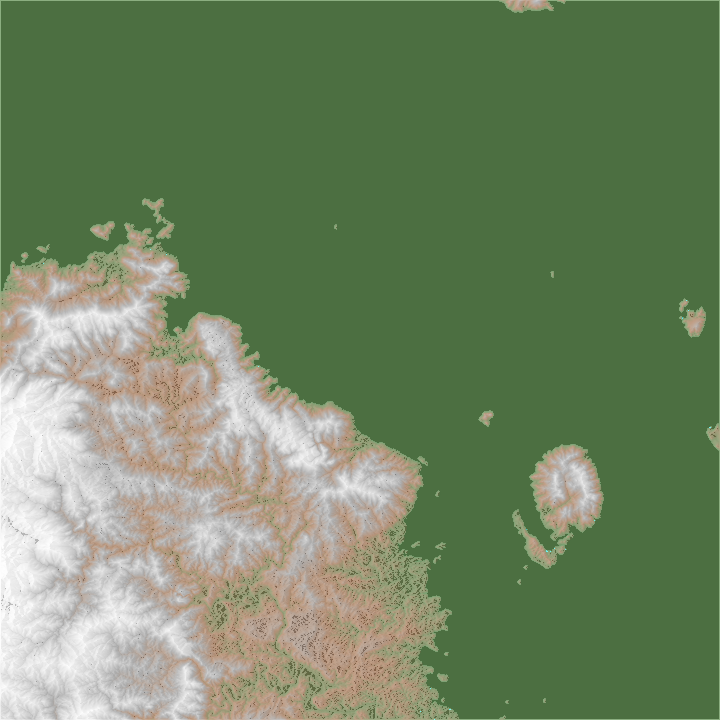

In [6]:
# Render the hillshade with a coloramp of the values applied on top
shaded = hillshade(da, azimuth=100, angle_altitude=50)
stack(shade(shaded, cmap=["white", "gray"]), shade(da, cmap=Elevation, alpha=128))